<a href="https://colab.research.google.com/github/OxML2020/practicals/blob/master/OxML2020_RL2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
#OxML 2020: Reinforcement Learning Part 2

**Temporal-Difference Learning and Q-Learning**

**content creator:** Fatemeh Abdollahi


---





In [2]:
#@title Setup

#######################################################################
# Copyright (C)                                                       #
# 2016 Shangtong Zhang(zhangshangtong.cpp@gmail.com)                  #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt


#Section 1: Introduction to TD Learning

__MDPs:__

Finite Markov decision processes (MDPs) are a classical formalization of sequential decision making, where actions influence not just immediate rewards, but also subsequent situations, or states, and future rewards.
Thus MDPs involve delayed reward and the need to tradeoff immediate and delayed rewards. Whereas in bandit problems we estimated the value $q_{*}(a)$ of each action $a$, in MDPs we estimate the value $q_{*}(s, a)$ of each action $a$
in each state $s$, or we estimate the value $v_{*}(s)$ of each state given optimal action selections.
These state-dependent quantities are essential to accurately assigning credit for long-term consequences to individual action selections.
MDPs are a mathematically idealized form of the reinforcement learning problem
for which precise theoretical statements can be made.

__Environment:__

- In a finite MDP, the sets of states, actions, and rewards ($S, A$, and $R$) all have a finite number of elements. In this case, the random variables $R_{t}$ and $S_{t}$ have well defined discrete probability distributions dependent only on the preceding state and action. That is, for particular values of these random variables, $s' \in S$ and $r \in R$, there is a probability of those values occurring at time $t$, given particular values of the preceding state and action:
\begin{align}
p(s', r|s, a) \doteq \Pr [ S_{t}=s', R_{t}=r \;|\; S_{t−1}=s, A_{t−1}=a]
\end{align}
for all $s', s \in S, r \in R$, and $a \in A(s)$. The function $p$ defines the dynamics of the MDP.
- The agent experiences the environment in episodes or trials.
- The agent's goal is to learn to predict expected rewards from each state in the trial. 


**Key Elements**

* Return $G_{t}$: future cumulative reward, which can be written in arecursive form
\begin{align}
G_{t} &= \sum \limits_{k = 0}^{\infty} \gamma^{k} R_{t+k+1} \\
&= R_{t+1} + \gamma G_{t+1}
\end{align}
where $\gamma$ is discount factor that controls the importance of future rewards, and $\gamma \in [0, 1]$. $\gamma$ may also be interpreted as probability of continuing the trajectory.
* Value funtion $V_{\pi}(s_t=s)$: expecation of the return for a state $s$ under policy $\pi$
\begin{align}
V_{\pi}(s_t=s) &= \mathbb{E} [ G_{t}\; | \; s_t=s, a_{t:\infty}\sim\pi] \\
& = \mathbb{E} [ R_{t+1} + \gamma G_{t+1}\; | \; s_t=s, a_{t:\infty}\sim\pi]
\end{align}
With an assumption of **Markov process**, we thus have:
\begin{align}
V_{\pi}(s_t=s) &= \mathbb{E} [ r_{t+1} + \gamma V_{\pi}(s_{t+1})\; | \; s_t=s, a_{t:\infty}\sim\pi] \\
&= \sum_a \pi(a|s) \sum_{r, s'}p(s', r | s, a)[r + V_{\pi}(s_{t+1}=s')]
\end{align}
where $\pi(a|s)$ is the probability of taking action $a$ in state $s$ under policy $\pi$.

**Temporal difference (TD) learning**

* With a Markovian assumption, we can use $V(s_{t+1})$ as an imperfect proxy for the true value $G_{t+1}$ (Monte Carlo bootstrapping), and thus obtain the generalised equation to calculate TD-error:
\begin{align}
\delta_{t} = R_{t+1} + \gamma V(S_{t+1}) - V(S_{t})
\end{align}

* Value updated by using the learning rate constant $\alpha$:
\begin{align}
V(S_{t}) \leftarrow V(S_{t}) + \alpha \delta_{t}
\end{align}



__Definitions:__

* TD-error:
\begin{align}
\delta_{t} = R_{t+1} + \gamma V(S_{t+1}) - V(S_{t})
\end{align}

* Value updates:
\begin{align}
V(S_{t}) \leftarrow V(S_{t}) + \alpha \delta_{t}
\end{align}


##Exercise 1: Implementing TD Algorithm

__Problem Definition:__

This is an example found in the book Reinforcement Learning: An Introduction by Sutton and Barto. The basic idea is that you always start in state ‘C’, and you move randomly, with a 50% probability, to either the left or right until you reach the terminal or ending states ‘A’ or ‘E’. If you end in state ‘A’, you get a reward of 0, but if you end in state ‘E’, the reward is 1. There are no rewards for states ‘B’ through ‘D’.

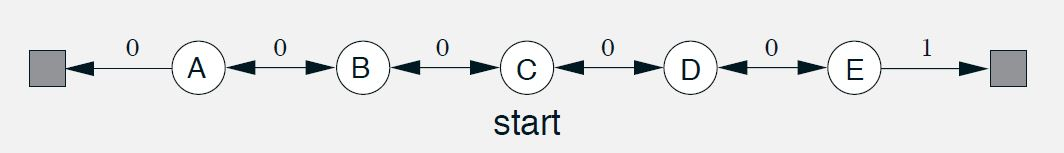

Using reinforcement learning on this example is to see if we can accurately predict each of these states' values through a model-free approach. The ground truth values are simply the probabilities for each state to gain a reward w.r.t. ending in state 'E'. The table below indicates the true value for each of the states that we'll measure our estimates against. Let's talk about our models and what temporal difference is now that we know our data/environment and the target values.

States | $V_{\pi}$
---|:---:
A|$\frac{1}{6}$
B|$\frac{2}{6}$
C|$\frac{3}{6}$
D|$\frac{4}{6}$
E|$\frac{5}{6}$

Now, let's implement the TD-Learning algorithm.

In [ ]:
# 0 is the left terminal state 
# 6 is the right terminal state 
# 1 ... 5 represents A ... E
states = np.zeros(7)
states[1:6] = 0.5
# For convenience, we assume all rewards are 0
# and the left terminal state has value 0, the right terminal state has value 1
# This trick has been used in Gambler's Problem
states[6] = 1

# set up true state values
trueValue = np.zeros(7)
trueValue[1:6] = np.arange(1, 6) / 6.0
trueValue[6] = 1

ACTION_LEFT = 0
ACTION_RIGHT = 1

# @states: current states value, will be updated
# @alpha: step size
def temporalDifference(states, alpha=0.05):
    #starting from C
    state = 3
    trajectory = [state]
    rewards = [0]
    while True:
        oldState = state
        #walking randomly
        if np.random.binomial(1, 0.5) == ACTION_LEFT:
            state -= 1
        else:
            state += 1
        # Assume all rewards are 0
        reward = 0
        trajectory.append(state)
        # TD update
        states[oldState] = ...
        if state == 6 or state == 0:
            break
        rewards.append(reward)
    return trajectory, rewards


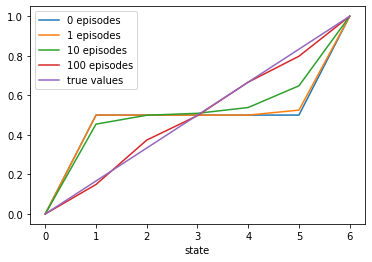

In [ ]:
#@title State Values

def stateValue():
    episodes = [0,1, 10, 100]
    currentStates = np.copy(states)
    plt.figure(1)
    axisX = np.arange(0, 7)
    for i in range(0, episodes[-1] + 1):
        if i in episodes:
            plt.plot(axisX, currentStates, label=str(i) + ' episodes')
        temporalDifference(currentStates)
    plt.plot(axisX, trueValue, label='true values')
    plt.xlabel('state')
    plt.legend()

stateValue()

#Section 2: Introduction to Q-Learning

__Grid Worlds:__

As pointed out, bandits only have a single state and immediate rewards for our actions. Many problems we are interested in have multiple states and delayed rewards, i.e. we won't know if the choices we made will pay off over time, or which actions we took contributed to the outcomes we observed.

To explore these ideas, we turn a common problem setting: the grid world. Grid worlds are simple environments where each state corresponds to a tile on a 2D grid, and the only actions the agent can take are to move up, down, left, or right across the grid tiles. The agent's job is almost always to find a way to a goal tile in the most direct way possible while overcoming some maze or other obstacles, either static or dynamic.

For our discussion, we will be looking at the classic Cliff World, or Cliff Walker, environment. This is a 4x12 grid with a starting position in the lower-left and the goal position in the lower-right. Every tile between these two is the "cliff." If the agent enters the cliff, they will receive a -100 reward and be sent back to the starting position. Every tile other than the cliff produces a -1 reward when entered. The goal tile ends the episode after taking any action from it.

<img alt="CliffWorld" width="577" height="308" src="https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/W2D5_ReinforcementLearning/static/W2D5_Tutorial3_CliffWorld.png?raw=true">

Given these conditions, the maximum achievable reward is -12 (1 up, 11 right, 1 down). Using negative rewards is a common technique to encourage the agent to move and seek out the goal state as fast as possible.

---
__Q-Learning:__

Now that we have our environment, how can we solve it? 

One of the most famous algorithms for estimating action values (aka Q-values) is the **Off-policy** Temporal Differences (TD) **control** algorithm known as *Q-learning* (Watkins, 1989). 

\begin{align}
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha \big(R_t + \gamma\max_\limits{a} Q(S_{t+1},a) - Q(S_t,A_t)\big)
\end{align}

where $Q(s,a)$ is the value function for action $a$ at state $s$, $\alpha$ is the learning rate, $r$ is the reward, and $\gamma$ is the temporal discount rate.

The expression $R_t + \gamma\max_\limits{a} Q(S_{t+1},a)$ is referred to as the TD target while the full expression 
\begin{align}
R_t + \gamma\max_\limits{a} Q(S_{t+1},a) - Q(S_t,A_t),
\end{align}
i.e. the difference between the TD target and the current Q-value, is referred to as the TD error, or reward prediction error.

Because the max operator used to select the optimal Q-value in the TD target, Q-learning directly estimates the optimal action value, i.e. the cumulative future reward that would be obtained if the agent behaved optimally, independent of the policy currently being followed by the agent. For this reason, Q-learning is referred to as an **off-policy** method.

##Exercise 2: Implementing Q-Learning

In this exercise you will implement the Q-learning update rule described above. 

Please read the environment setup carefully.

In [32]:
#@title Environment Setup

# world height
WORLD_HEIGHT = 4

# world width
WORLD_WIDTH = 12

# probability for exploration
EPSILON = 0.1

# step size
ALPHA = 0.5

# gamma for Q-Learning and Expected Sarsa
GAMMA = 1

# all possible actions
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3
actions = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]

# initial state action pair values
stateActionValues = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
startState = [3, 0]
goalState = [3, 11]

# reward for each action in each state
actionRewards = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
actionRewards[:, :, :] = -1.0
#walking thorough Cliff
actionRewards[2, 1:11, ACTION_DOWN] = -100.0
actionRewards[3, 0, ACTION_RIGHT] = -100.0

# set up destinations for each action in each state
#(determine next states after taking all posible actions)
actionDestination = []
for i in range(0, WORLD_HEIGHT):
    actionDestination.append([])
    for j in range(0, WORLD_WIDTH):
        destinaion = dict()
        destinaion[ACTION_UP] = [max(i - 1, 0), j]
        destinaion[ACTION_LEFT] = [i, max(j - 1, 0)]
        destinaion[ACTION_RIGHT] = [i, min(j + 1, WORLD_WIDTH - 1)]
        if i == 2 and 1 <= j <= 10:
            destinaion[ACTION_DOWN] = startState
        else:
            destinaion[ACTION_DOWN] = [min(i + 1, WORLD_HEIGHT - 1), j]
        actionDestination[-1].append(destinaion)
actionDestination[3][0][ACTION_RIGHT] = startState

In [33]:
#@title Helper Function

#######################################################################
# Copyright (C)                                                       #
# 2016 Shangtong Zhang(zhangshangtong.cpp@gmail.com)                  #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt


# print optimal policy
def printOptimalPolicy(stateActionValues):
    optimalPolicy = []
    for i in range(0, WORLD_HEIGHT):
        optimalPolicy.append([])
        for j in range(0, WORLD_WIDTH):
            if [i, j] == goalState:
                optimalPolicy[-1].append('G')
                continue
            bestAction = np.argmax(stateActionValues[i, j, :])
            if bestAction == ACTION_UP:
                optimalPolicy[-1].append('U')
            elif bestAction == ACTION_DOWN:
                optimalPolicy[-1].append('D')
            elif bestAction == ACTION_LEFT:
                optimalPolicy[-1].append('L')
            elif bestAction == ACTION_RIGHT:
                optimalPolicy[-1].append('R')
    for row in optimalPolicy:
        print(row)

# choose an action based on epsilon greedy algorithm
def chooseAction(state, stateActionValues):
    if np.random.binomial(1, EPSILON) == 1:
        return np.random.choice(actions)
    else:
        values_ = stateActionValues[state[0], state[1], :]
        return np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])

def takeAction(currentState, currentAction):
  newState = actionDestination[currentState[0]][currentState[1]][currentAction]
  reward = actionRewards[currentState[0], currentState[1], currentAction]
  return newState, reward


You can use ``` chooseAction(state, stateActionValues) ``` and ``` takeAction(state, action) ``` and ``` np.max([...]) ```.



In [34]:
# an episode with Q-Learning
# @stateActionValues: values for state action pair, will be updated
# @stepSize: step size for updating
# @return: total rewards within this episode
def qLearning(stateActionValues, stepSize=ALPHA):
    currentState = startState
    rewards = 0.0
    while currentState != goalState:
        currentAction = ...
        newState, reward = ...
        rewards += reward
        # Q-Learning update
        stateActionValues[currentState[0], currentState[1], currentAction] = ...
        #going to the nest state and continueing the episode
        ...
    return rewards


#Section 3: Introduction to SARSA

An alternative to Q-learning, the SARSA algorithm, also estimates action values. However, rather than estimating the optimal (off-policy) values, SARSA estimates the **on-policy** action value (On-policy TD Control), i.e. the cumulative future reward that would be obtained if the agent behaved according to its current beliefs.

\begin{align}
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha \big(R_t + \gamma Q(S_{t+1},A_{t+1}) - Q(S_t,A_t)\big)
\end{align}

where, once again, $Q(s,a)$ is the value function for action $a$ at state $s$, $\alpha$ is the learning rate, $R-{t}$ is the reward, and $\gamma$ is the temporal discount rate.

In fact, you will notice that the *only* difference between Q-learning and SARSA is the TD target calculation uses the policy to select the next action (in our case, epsilon-greedy) than using the action that maximizes the Q-value.

## Exercise 2: Implementing the SARSA algorithm

In this exercise you will implement the SARSA update rule described above. 


In [35]:
# an episode with Sarsa
# @stateActionValues: values for state action pair, will be updated
# @stepSize: step size for updating
# @return: total rewards within this episode
def sarsa(stateActionValues, stepSize=ALPHA):
    currentState = startState
    currentAction = ...
    rewards = 0.0
    while currentState != goalState:
        newState, reward = ...
        newAction = ...
        rewards += reward
        #Q(newState, newAction) using stateActionValues[...]
        valueTarget = ...
        valueTarget *= GAMMA
        # Sarsa update
        stateActionValues[currentState[0], currentState[1], currentAction] = ...
        currentState = newState
        currentAction = newAction
    return rewards


Now, we have completed the SARSA and Q-Learning; let's see the difference between these two algorithms!
To compare them, we run both algorithms 20 times; each run has 500 episodes. So we can have a smooth learning curve!

Please run the code block below and try to ask these questions:

1. Which one is faster?
2. Which one is optimal?
3. Which one comes up with a safer path?

Sarsa Optimal Policy:
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['U', 'U', 'R', 'R', 'U', 'R', 'U', 'U', 'U', 'U', 'R', 'D']
['U', 'U', 'U', 'R', 'U', 'U', 'L', 'R', 'R', 'R', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'G']
Q-Learning Optimal Policy:
['R', 'U', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D', 'D']
['R', 'D', 'R', 'R', 'D', 'R', 'D', 'R', 'R', 'R', 'D', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'G']


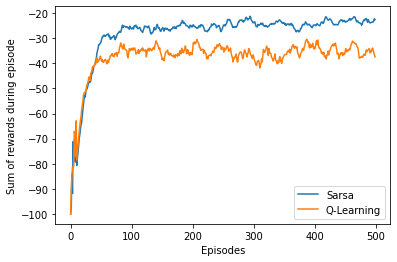

In [36]:
#@title Comparing Sarsa and Q-Learning on Cliff Walk
def learning_curve():
    # averaging the reward sums from 10 successive episodes
    averageRange = 10

    # episodes of each run
    nEpisodes = 500

    # perform 20 independent runs
    runs = 20

    rewardsSarsa = np.zeros(nEpisodes)
    rewardsQLearning = np.zeros(nEpisodes)
    for run in range(0, runs):
        stateActionValuesSarsa = np.copy(stateActionValues)
        stateActionValuesQLearning = np.copy(stateActionValues)
        for i in range(0, nEpisodes):
            # cut off the value by -100 to draw the figure more elegantly
            rewardsSarsa[i] += max(sarsa(stateActionValuesSarsa), -100)
            rewardsQLearning[i] += max(qLearning(stateActionValuesQLearning), -100)

    # averaging over independt runs
    rewardsSarsa /= runs
    rewardsQLearning /= runs

    # averaging over successive episodes
    smoothedRewardsSarsa = np.copy(rewardsSarsa)
    smoothedRewardsQLearning = np.copy(rewardsQLearning)
    for i in range(averageRange, nEpisodes):
        smoothedRewardsSarsa[i] = np.mean(rewardsSarsa[i - averageRange: i + 1])
        smoothedRewardsQLearning[i] = np.mean(rewardsQLearning[i - averageRange: i + 1])

    # display optimal policy
    print('Sarsa Optimal Policy:')
    printOptimalPolicy(stateActionValuesSarsa)
    print('Q-Learning Optimal Policy:')
    printOptimalPolicy(stateActionValuesQLearning)

    # draw reward curves
    plt.figure(1)
    plt.plot(smoothedRewardsSarsa, label='Sarsa')
    plt.plot(smoothedRewardsQLearning, label='Q-Learning')
    plt.xlabel('Episodes')
    plt.ylabel('Sum of rewards during episode')
    plt.legend()

learning_curve()
plt.show()

What should immediately jump out is that Q-learning learned to go up, then quickly go to the right, skirting the cliff edge, until it hits the wall and goes down to the goal. The policy further away from the cliff is less certain.

On the other hand, SARSA appears to avoid the cliff edge, going up one more tile before starting over to the goal side. This also clearly solves the challenge of getting to the goal but does so at an additional -2 cost over the truly optimal route.

Why do you think these behaviours emerged the way they did?

In video below, you can watch how Q-Learning algorithm learns step by step! Enjoy it.

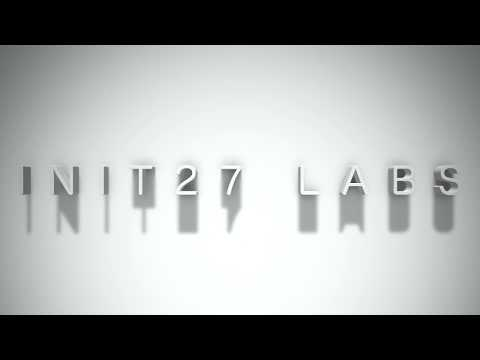

In [50]:
#@title (Video) How Q-Learning is Learning?
from IPython.display import YouTubeVideo
YouTubeVideo('Vto8n9C7DSQ')

#References

1. Neuromatch [RL Tutorial](https://github.com/NeuromatchAcademy/course-content/tree/master/tutorials/W2D5_ReinforcementLearning)
2. [RL an introduction -solutions](https://github.com/JaeDukSeo/reinforcement-learning-an-introduction/blob/master/chapter02/TenArmedTestbed.py)
3. [RL an introduction, second edition](http://www.incompleteideas.net/book/the-book.html)